In [2]:
from funciones_helmholtz_bem import Circle_n
from funciones_helmholtz_bem import frequencyToWavenumber
from funciones_helmholtz_bem import solveExteriorBoundary
from funciones_helmholtz_bem import solveExterior
from funciones_helmholtz_bem import phi_test_problem_1_2
from funciones_helmholtz_bem import generateInteriorPoints_test_problem_2
from funciones_helmholtz_bem import plot_solutions
from funciones_helmholtz_bem import plot_edges_and_field
from funciones_helmholtz_bem import generateInteriorPoints_excluding_circle
from funciones_helmholtz_bem import sound_hard_circle_calc
from funciones_helmholtz_bem import mask_displacement
from funciones_helmholtz_bem import plot_exact_displacement
from funciones_helmholtz_bem import plot_bem_displacements
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from numpy.linalg import norm
# reload kernel
%load_ext autoreload
%autoreload 2

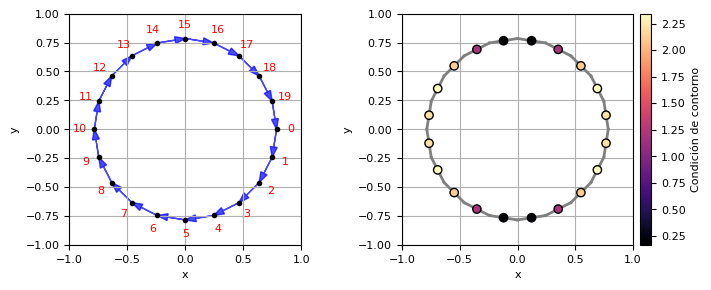

In [3]:
"""
Grafica ilistrativa de los bordes 
"""
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 20

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

# Grafica de los bordes
plot_edges_and_field(aVertex, aElement, aCenters, f)

In [4]:
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 300

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal

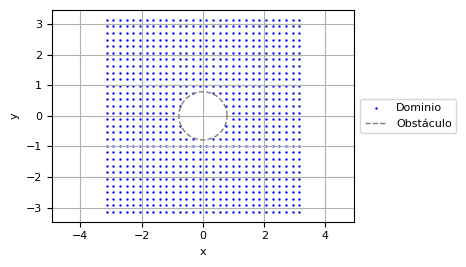

In [5]:
# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 30
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-np.pi, xmax=np.pi,
    ymin=-np.pi, ymax=np.pi,
    r_exclude=np.pi / 4
)

plt.figure(figsize=(4.5, 2.5))
plt.scatter(points_outside[:, 0], points_outside[:, 1], color='blue', s=0.5, label='Dominio')
#plt.scatter(points_inside[:, 0], points_inside[:, 1], color='red', s=5, label='Dentro del círculo')

# Dibujar el círculo excluido para referencia visual
theta = np.linspace(0, 2 * np.pi, 300)
r_exclude = np.pi / 4
x_circ = r_exclude * np.cos(theta)
y_circ = r_exclude * np.sin(theta)
plt.plot(x_circ, y_circ, '--', color='gray', label='Obstáculo', linewidth=1.0)

plt.axis('equal')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.tight_layout()
plt.savefig("domain_points.svg", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 40
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-np.pi, xmax=np.pi,
    ymin=-np.pi, ymax=np.pi,
    r_exclude=np.pi / 4
)

# Inicializar el potencial incidente en los puntos exteriores como cero
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

In [7]:
c, density = None, None  # Se puede cambiar si se tienen valores iniciales
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

In [7]:
# Evaluar el potencial numérico en los puntos del dominio exterior
interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

In [8]:
r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]


# Interpolar datos en la grilla
grid_z = griddata(points_outside, interiorPhi, (X, Y), method='cubic')
 

grid_z = np.ma.masked_where((X**2 + Y**2) < r_exclude, grid_z)

u_scn_amp = grid_z.real
u_scn_phase = grid_z.imag

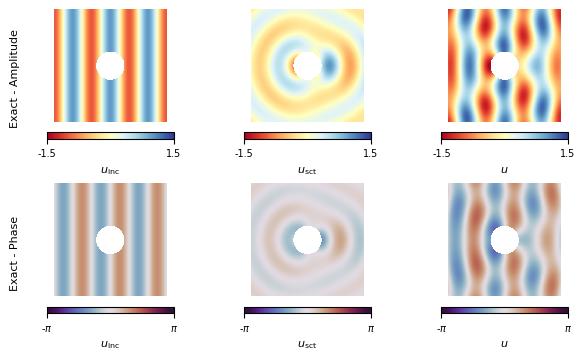

In [9]:
# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Plot the displacement amplitude
plot_exact_displacement(X, Y, np.real(u_inc_exact), np.real(u_scn_exact), np.real(u_exact), np.imag(u_inc_exact), np.imag(u_scn_exact), np.imag(u_exact))

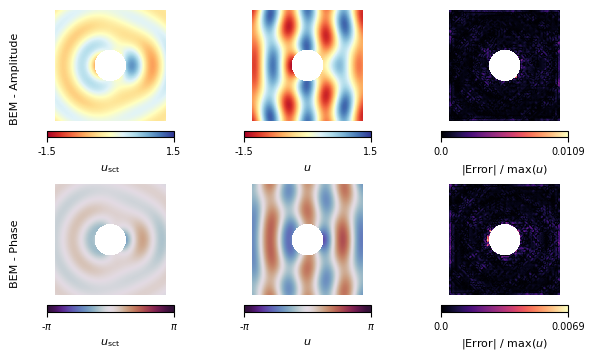

In [10]:
plot_bem_displacements(X, Y, u_scn_amp, np.real(u_inc_exact) + u_scn_amp, np.abs(np.real(u_scn_exact)-u_scn_amp), u_scn_phase, u_scn_phase+np.real(u_inc_exact), np.abs(np.imag(u_scn_exact)-u_scn_phase))

In [12]:
u_scn_exact = np.nan_to_num(u_scn_exact.data, nan=0.0)
u_scn_amp = np.nan_to_num(u_scn_amp.data, nan=0.0)
 

relative_error = np.linalg.norm(u_scn_exact.real - u_scn_amp.real, 2)/np.linalg.norm(u_scn_exact.real, 2)
relative_error

np.float64(0.9999999999999999)